# Importations des librairies

In [128]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import pickle
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix,precision_score


# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Boîte à fonctions

In [2]:
def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object

def missing_presence(df, figsize):
    
    # Affichage de la forme du dataset
    print("Le dataset contient {} lignes et {} colonnes.".format(df.shape[0], df.shape[1]))
    
    # Proportion de valeurs nulles
    prop_nan_df = df.isna().sum().sum()/(df.shape[0]*df.shape[1])*100
    print('Il y a {:.2f}% de NaN.'.format(prop_nan_df))
    
    # Visualisation des valeurs non nulles
    df_null=(df.notnull().sum()/df.shape[0]).sort_values(ascending=False)*100
    
    # Création de la figure
    plt.figure(figsize=figsize)
    plt.style.use('ggplot')
    ax=sns.barplot(x=df_null.values, y=df_null.index, orient='h')
    plt.title('Proportion de valeurs présentes par colonne')
    plt.xticks(rotation=0)
    plt.yticks(fontsize=14)
    plt.ylabel("Nom de la colonne")
    plt.xlabel('Pourcentage de valeurs présentes (%)')

    # Affichage de la valeur à côté des barres
    for index, value in enumerate(df_null.values):
        plt.text(value, index+0.4, str(value.round(2)))

    plt.show()

    
def setup_plot():
    plt.rcParams["axes.grid.axis"] = "y"
    plt.rcParams["axes.grid"] = True
    plt.rcParams["legend.fontsize"] = 14
    plt.rc('grid', linestyle="dashed", color='lightgrey', linewidth=1)
    plt.rcParams["xtick.labelsize"] = 15
    plt.rcParams["ytick.labelsize"] = 15

def select_col_by_type(df,col_type) : 
    var_object = []
    for col in df.select_dtypes(col_type) :
        var_object.append(col)
    return var_object
def handle_type(df) :
    cat_var = select_col_by_type(df,"object")
    int_var = select_col_by_type(df,"int")
    float_var = select_col_by_type(df,"float")
    num_var = int_var + float_var
    return cat_var, num_var
def imputer_nan(df, strategy, var_type):
    imputer = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imputer = imputer.fit(df[var_type])
    array_type = imputer.transform(df[var_type])
    df_type = pd.DataFrame(array_type, columns=var_type)
    return df_type

def trans_func():
    control_train = pd.read_csv(data_path +'application_train.csv')
    train_data = control_train[control_train.columns[control_train.isna().sum()/control_train.shape[0] < 0.5]]
    cat_var, num_var = handle_type(train_data)
    df_cat = imputer_nan(train_data, "most_frequent", cat_var)
    df_num = imputer_nan(train_data, "median", num_var)
    dummies = pd.get_dummies(df_cat, drop_first=True)
    concatenate_df = pd.concat([df_num, dummies], axis=1)
    data = concatenate_df.sample(n=500, random_state=1)
    return data

# Exploration, création, modification et suppression de variables

In [3]:
data_path = "../P07_kakpo_Fiacre/input/"

In [4]:
# Read in bureau
bureau = pd.read_csv(data_path + 'bureau.csv')
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [5]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

SK_ID_CURR  previous_loan_counts
0      100001                     7
1      100002                     8
2      100003                     4
3      100004                     2
4      100005                     3

In [6]:
# Join to the training dataframe
train = pd.read_csv(data_path +'application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0   
1  ...                 0                0                0   
2  ...                 0                0                0   
3  ...                 0                0                0   
4  ...                 0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   

  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        NaN                        NaN   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  previous_loan_counts  
0                        0.0                         1.0                   8.0  
1                        0.0                         0.0                   4.0  
2                        0.0                         0.0                   2.0  
3                        NaN                         NaN                   0.0  
4                        0.0                         0.0                   1.0  

[5 rows x 123 columns]

In [7]:
# Plots the disribution of a variable colored by value of the target
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend();
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)
    

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid =     0.5460


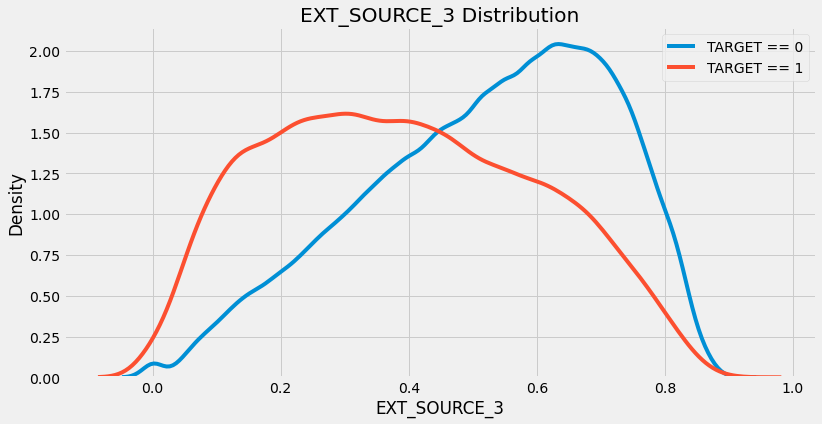

In [8]:
kde_target('EXT_SOURCE_3', train)

The correlation between previous_loan_counts and the TARGET is -0.0100
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid =     4.0000


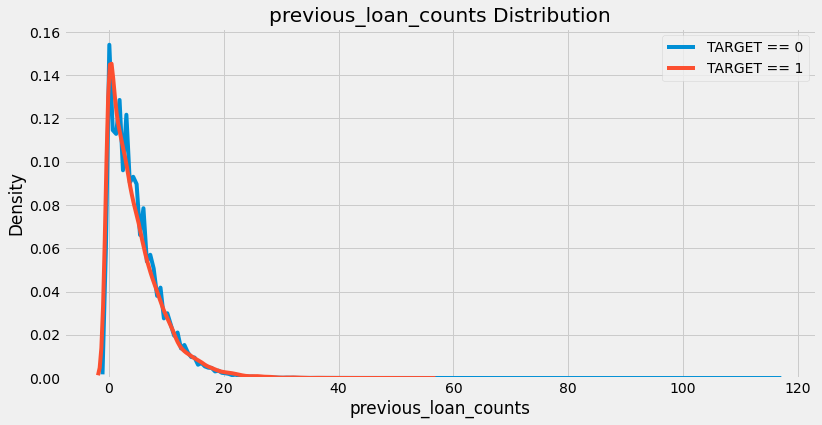

In [9]:
kde_target('previous_loan_counts', train)

## Aggregation des colonnes de type Numerique

In [10]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

In [11]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [12]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  ...  \
0                              0                              0  ...   
1                              0                              0  ...   
2                              0                              0  ...   
3                              0                              0  ...   
4                              0                              0  ...   

   bureau_DAYS_CREDIT_UPDATE_count  bureau_DAYS_CREDIT_UPDATE_mean  \
0                                7                      -93.142857   
1                                8                     -499.875000   
2                                4                     -816.000000   
3                                2                     -532.000000   
4                                3                      -54.333333   

   bureau_DAYS_CREDIT_UPDATE_max  bureau_DAYS_CREDIT_UPDATE_min  \
0                             -6                           -155   
1                             -7                          -1185   
2                            -43                          -2131   
3                           -382                           -682   
4                            -11                           -121   

   bureau_DAYS_CREDIT_UPDATE_sum  bureau_AMT_ANNUITY_count  \
0                           -652                         7   
1                          -3999                         7   
2                          -3264                         0   
3                          -1064                         0   
4                           -163                         3   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0              3545.357143                 10822.5                     0.0   
1                 0.000000                     0.0                     0.0   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4              1420.500000                  4261.5                     0.0   

   bureau_AMT_ANNUITY_sum  
0                 24817.5  
1                     0.0  
2                     0.0  
3                     0.0  
4                  4261.5  

[5 rows x 61 columns]

Now we simply merge with the training data as we did before.

In [13]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  bureau_DAYS_CREDIT_UPDATE_count bureau_DAYS_CREDIT_UPDATE_mean  \
0  ...                              8.0                       -499.875   
1  ...                              4.0                       -816.000   
2  ...                              2.0                       -532.000   
3  ...                              NaN                            NaN   
4  ...                              1.0                       -783.000   

  bureau_DAYS_CREDIT_UPDATE_max bureau_DAYS_CREDIT_UPDATE_min  \
0                          -7.0                       -1185.0   
1                         -43.0                       -2131.0   
2                        -382.0                        -682.0   
3                           NaN                           NaN   
4                        -783.0                        -783.0   

  bureau_DAYS_CREDIT_UPDATE_sum bureau_AMT_ANNUITY_count  \
0                       -3999.0                      7.0   
1                       -3264.0                      0.0   
2                       -1064.0                      0.0   
3                           NaN                      NaN   
4                        -783.0                      0.0   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0                      0.0                     0.0                     0.0   
1                      NaN                     NaN                     NaN   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4                      NaN                     NaN                     NaN   

   bureau_AMT_ANNUITY_sum  
0                     0.0  
1                     0.0  
2                     0.0  
3                     NaN  
4                     0.0  

[5 rows x 183 columns]

### Correlations des variables agregées avec la Target

In [14]:
# List of new correlations
new_corrs = []

# Iterate through the columns 
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])
    
    # Append the list as a tuple

    new_corrs.append((col, corr))

In [15]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.08972896721998122),
 ('bureau_DAYS_CREDIT_min', 0.0752482510301036),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968668),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.05588737984392113),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.05373489560102051),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758661),
 ('bureau_DAYS_CREDIT_max', 0.049782054639973095),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.04885350261111589),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483543),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.042863922470730176),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484684),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.04140363535306004),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.036589634696329046),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.03428110992161599),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.030492306653325547)]

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.0897
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid =     -1067.0000


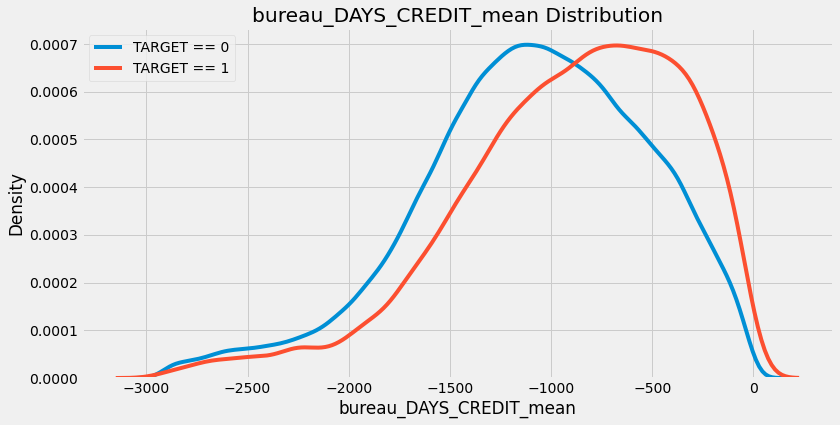

In [16]:
kde_target('bureau_DAYS_CREDIT_mean', train)

## Fonction globale pour aggréger les variables de type Numérique

In [17]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [18]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  ...  \
0                              0                              0  ...   
1                              0                              0  ...   
2                              0                              0  ...   
3                              0                              0  ...   
4                              0                              0  ...   

   bureau_DAYS_CREDIT_UPDATE_count  bureau_DAYS_CREDIT_UPDATE_mean  \
0                                7                      -93.142857   
1                                8                     -499.875000   
2                                4                     -816.000000   
3                                2                     -532.000000   
4                                3                      -54.333333   

   bureau_DAYS_CREDIT_UPDATE_max  bureau_DAYS_CREDIT_UPDATE_min  \
0                             -6                           -155   
1                             -7                          -1185   
2                            -43                          -2131   
3                           -382                           -682   
4                            -11                           -121   

   bureau_DAYS_CREDIT_UPDATE_sum  bureau_AMT_ANNUITY_count  \
0                           -652                         7   
1                          -3999                         7   
2                          -3264                         0   
3                          -1064                         0   
4                           -163                         3   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0              3545.357143                 10822.5                     0.0   
1                 0.000000                     0.0                     0.0   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4              1420.500000                  4261.5                     0.0   

   bureau_AMT_ANNUITY_sum  
0                 24817.5  
1                     0.0  
2                     0.0  
3                     0.0  
4                  4261.5  

[5 rows x 61 columns]

In [19]:
bureau_agg.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  ...  \
0                              0                              0  ...   
1                              0                              0  ...   
2                              0                              0  ...   
3                              0                              0  ...   
4                              0                              0  ...   

   bureau_DAYS_CREDIT_UPDATE_count  bureau_DAYS_CREDIT_UPDATE_mean  \
0                                7                      -93.142857   
1                                8                     -499.875000   
2                                4                     -816.000000   
3                                2                     -532.000000   
4                                3                      -54.333333   

   bureau_DAYS_CREDIT_UPDATE_max  bureau_DAYS_CREDIT_UPDATE_min  \
0                             -6                           -155   
1                             -7                          -1185   
2                            -43                          -2131   
3                           -382                           -682   
4                            -11                           -121   

   bureau_DAYS_CREDIT_UPDATE_sum  bureau_AMT_ANNUITY_count  \
0                           -652                         7   
1                          -3999                         7   
2                          -3264                         0   
3                          -1064                         0   
4                           -163                         3   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0              3545.357143                 10822.5                     0.0   
1                 0.000000                     0.0                     0.0   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4              1420.500000                  4261.5                     0.0   

   bureau_AMT_ANNUITY_sum  
0                 24817.5  
1                     0.0  
2                     0.0  
3                     0.0  
4                  4261.5  

[5 rows x 61 columns]

###  Fonction pour gérer la correlation

In [20]:
# Function to calculate correlations with the target for a dataframe
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns 
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))
            
    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)
    
    return corrs

## Les variables catégorielles 

In [21]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  \
0                     0                       0                     1   
1                     1                       0                     0   
2                     1                       0                     0   
3                     1                       0                     0   
4                     1                       0                     0   

   CREDIT_ACTIVE_Sold  CREDIT_CURRENCY_currency 1  CREDIT_CURRENCY_currency 2  \
0                   0                           1                           0   
1                   0                           1                           0   
2                   0                           1                           0   
3                   0                           1                           0   
4                   0                           1                           0   

   CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  ...  \
0                                 0                     0  ...   
1                                 0                     0  ...   
2                                 0                     0  ...   
3                                 0                     0  ...   
4                                 0                     0  ...   

   CREDIT_TYPE_Loan for business development  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   CREDIT_TYPE_Loan for purchase of shares (margin lending)  \
0                                                  0          
1                                                  0          
2                                                  0          
3                                                  0          
4                                                  0          

   CREDIT_TYPE_Loan for the purchase of equipment  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   CREDIT_TYPE_Loan for working capital replenishment  CREDIT_TYPE_Microloan  \
0                                                  0                       0   
1                                                  0                       0   
2                                                  0                       0   
3                                                  0                       0   
4                                                  0                       0   

   CREDIT_TYPE_Mobile operator loan  CREDIT_TYPE_Mortgage  \
0                                 0                     0   
1                                 0                     0   
2                                 0                     0   
3                                 0                     0   
4                                 0                     0   

   CREDIT_TYPE_Real estate loan  CREDIT_TYPE_Unknown type of loan  SK_ID_CURR  
0                             0                                 0      215354  
1                             0                                 0      215354  
2                             0                                 0      215354  
3                             0                                 0      215354  
4                             0                                 0      215354 

In [22]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

In [23]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [24]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [25]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

CREDIT_ACTIVE_Active_count  CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                                                
100001                               3                         0.428571   
100002                               2                         0.250000   
100003                               1                         0.250000   
100004                               0                         0.000000   
100005                               2                         0.666667   

            CREDIT_ACTIVE_Bad debt_count  CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                                                    
100001                                 0                                0.0   
100002                                 0                                0.0   
100003                                 0                                0.0   
100004                                 0                                0.0   
100005                                 0                                0.0   

            CREDIT_ACTIVE_Closed_count  CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                                                
100001                               4                         0.571429   
100002                               6                         0.750000   
100003                               3                         0.750000   
100004                               2                         1.000000   
100005                               1                         0.333333   

            CREDIT_ACTIVE_Sold_count  CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                                            
100001                             0                            0.0   
100002                             0                            0.0   
100003                             0                            0.0   
100004                             0                            0.0   
100005                             0                            0.0   

            CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                     
100001                                     7   
100002                                     8   
100003                                     4   
100004                                     2   
100005                                     3   

            CREDIT_CURRENCY_currency 1_count_norm  ...  \
SK_ID_CURR                                         ...   
100001                                        1.0  ...   
100002                                        1.0  ...   
100003                                        1.0  ...   
100004                                        1.0  ...   
100005                                        1.0  ...   

            CREDIT_TYPE_Microloan_count  CREDIT_TYPE_Microloan_count_norm  \
SK_ID_CURR                                                                  
100001                                0                               0.0   
100002                                0                               0.0   
100003                                0                               0.0   
100004                                0                               0.0   
100005                                0                               0.0   

            CREDIT_TYPE_Mobile operator loan_count  \
SK_ID_CURR                                           
100001                                           0   
100002                                           0   
100003                                           0   
100004                                           0   
100005                                           0   

            CREDIT_TYPE_Mobile operator loan_count_norm  \
SK_ID_CURR                                                
100001                                              0.0   
100002                                              0.0   
100003   

In [26]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  CREDIT_TYPE_Microloan_count CREDIT_TYPE_Microloan_count_norm  \
0  ...                          0.0                              0.0   
1  ...                          0.0                              0.0   
2  ...                          0.0                              0.0   
3  ...                          NaN                              NaN   
4  ...                          0.0                              0.0   

  CREDIT_TYPE_Mobile operator loan_count  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    NaN   
4                                    0.0   

  CREDIT_TYPE_Mobile operator loan_count_norm CREDIT_TYPE_Mortgage_count  \
0                                         0.0                        0.0   
1                                         0.0                        0.0   
2                                         0.0                        0.0   
3                                         NaN                        NaN   
4                                         0.0                        0.0   

  CREDIT_TYPE_Mortgage_count_norm  CREDIT_TYPE_Real estate loan_count  \
0                             0.0                                 0.0   
1                             0.0                                 0.0   
2                             0.0                                 0.0   
3                             NaN                                 NaN   
4                             0.0                                 0.0   

   CREDIT_TYPE_Real estate loan_count_norm  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      NaN   
4                                      0.0   

   CREDIT_TYPE_Unknown type of loan_count  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     NaN   
4                                     0.0   

   CREDIT_TYPE_Unknown type of loan_count_norm  
0                                          0.0  
1                                          0.0  
2                                          0.0  
3                                          NaN  
4                                          0.0  

[5 rows x 229 columns]

In [27]:
train.shape

(307511, 229)

In [28]:
train.iloc[:10, 123:]

bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  bureau_DAYS_CREDIT_max  \
0                       8.0              -874.000000                  -103.0   
1                       4.0             -1400.750000                  -606.0   
2                       2.0              -867.000000                  -408.0   
3                       NaN                      NaN                     NaN   
4                       1.0             -1149.000000                 -1149.0   
5                       3.0              -757.333333                   -78.0   
6                      18.0             -1271.500000                  -239.0   
7                       2.0             -1939.500000                 -1138.0   
8                       4.0             -1773.000000                 -1309.0   
9                       NaN                      NaN                     NaN   

   bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                 -1437.0                 -6992.0   
1                 -2586.0                 -5603.0   
2                 -1326.0                 -1734.0   
3                     NaN                     NaN   
4                 -1149.0                 -1149.0   
5                 -1097.0                 -2272.0   
6                 -2882.0                -22887.0   
7                 -2741.0                 -3879.0   
8                 -2508.0                 -7092.0   
9                     NaN                     NaN   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                              8.0                             0.0   
1                              4.0                             0.0   
2                              2.0                             0.0   
3                              NaN                             NaN   
4                              1.0                             0.0   
5                              3.0                             0.0   
6                             18.0                             0.0   
7                              2.0                             0.0   
8                              4.0                             0.0   
9                              NaN                             NaN   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            NaN                            NaN   
4                            0.0                            0.0   
5                            0.0                            0.0   
6                            0.0                            0.0   
7                            0.0                            0.0   
8                            0.0                            0.0   
9                            NaN                            NaN   

   bureau_CREDIT_DAY_OVERDUE_sum  ...  CREDIT_TYPE_Microloan_count  \
0                            0.0  ...                          0.0   
1                            0.0  ...                          0.0   
2                            0.0  ...                          0.0   
3                            NaN  ...                          NaN   
4                            0.0  ...                          0.0   
5                            0.0  ...                          0.0   
6                            0.0  ...                          0.0   
7                            0.0  ...                          0.0   
8                            0.0  ...                          0.0   
9                            NaN  ...                          NaN   

   CREDIT_TYPE_Microloan_count_norm  CREDIT_TYPE_Mobile operator loan_count  \
0                               0.0                                     0.0   
1                               0.0                                     0.0   
2                    

### Fonction pour le traitement des variables catégorielles

In [29]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [30]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

bureau_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      3   
100002                                      2   
100003                                      1   
100004                                      0   
100005                                      2   

            bureau_CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                           
100001                                    0.428571   
100002                                    0.250000   
100003                                    0.250000   
100004                                    0.000000   
100005                                    0.666667   

            bureau_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        0   
100002                                        0   
100003                                        0   
100004                                        0   
100005                                        0   

            bureau_CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                             
100001                                           0.0   
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   

            bureau_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      4   
100002                                      6   
100003                                      3   
100004                                      2   
100005                                      1   

            bureau_CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                           
100001                                    0.571429   
100002                                    0.750000   
100003                                    0.750000   
100004                                    1.000000   
100005                                    0.333333   

            bureau_CREDIT_ACTIVE_Sold_count  \
SK_ID_CURR                                    
100001                                    0   
100002                                    0   
100003                                    0   
100004                                    0   
100005                                    0   

            bureau_CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            bureau_CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                            
100001                                            7   
100002                                            8   
100003                                            4   
100004                                            2   
100005                                            3   

            bureau_CREDIT_CURRENCY_currency 1_count_norm  ...  \
SK_ID_CURR                                                ...   
100001                                               1.0  ...   
100002                                               1.0  ...   
100003                                               1.0  ...   
100004                                               1.0  ...   
100005                                               1.0  ...   

            bureau_CREDIT_TYPE_Microloan_count  \
SK_ID_CURR                                       
100001                                       0   
100002                                       0   
100003                                       0   
100004                      

## Répeter le traitement avec le jeu de données Bureau_balance

In [31]:
# Read in bureau balance
bureau_balance = pd.read_csv(data_path +'bureau_balance.csv')
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [32]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

bureau_balance_STATUS_0_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   5   
5001711                                   3   
5001712                                  10   
5001713                                   0   

              bureau_balance_STATUS_0_count_norm  \
SK_ID_BUREAU                                       
5001709                                 0.000000   
5001710                                 0.060241   
5001711                                 0.750000   
5001712                                 0.526316   
5001713                                 0.000000   

              bureau_balance_STATUS_1_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_1_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_2_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_2_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_3_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_3_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_4_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_4_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_5_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_5_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5

In [33]:
# Calculate value count statistics for each `SK_ID_CURR` 
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count  \
0       5001709                                   97   
1       5001710                                   83   
2       5001711                                    4   
3       5001712                                   19   
4       5001713                                   22   

   bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max  \
0                               -48.0                                  0   
1                               -41.0                                  0   
2                                -1.5                                  0   
3                                -9.0                                  0   
4                               -10.5                                  0   

   bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum  
0                                -96                              -4656  
1                                -82                              -3403  
2                                 -3                                 -6  
3                                -18                               -171  
4                                -21                               -231

In [34]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

SK_ID_BUREAU  bureau_balance_MONTHS_BALANCE_count  \
0       5001709                                   97   
1       5001710                                   83   
2       5001711                                    4   
3       5001712                                   19   
4       5001713                                   22   

   bureau_balance_MONTHS_BALANCE_mean  bureau_balance_MONTHS_BALANCE_max  \
0                               -48.0                                  0   
1                               -41.0                                  0   
2                                -1.5                                  0   
3                                -9.0                                  0   
4                               -10.5                                  0   

   bureau_balance_MONTHS_BALANCE_min  bureau_balance_MONTHS_BALANCE_sum  \
0                                -96                              -4656   
1                                -82                              -3403   
2                                 -3                                 -6   
3                                -18                               -171   
4                                -21                               -231   

   bureau_balance_STATUS_0_count  bureau_balance_STATUS_0_count_norm  \
0                              0                            0.000000   
1                              5                            0.060241   
2                              3                            0.750000   
3                             10                            0.526316   
4                              0                            0.000000   

   bureau_balance_STATUS_1_count  bureau_balance_STATUS_1_count_norm  ...  \
0                              0                                 0.0  ...   
1                              0                                 0.0  ...   
2                              0                                 0.0  ...   
3                              0                                 0.0  ...   
4                              0                                 0.0  ...   

   bureau_balance_STATUS_3_count_norm  bureau_balance_STATUS_4_count  \
0                                 0.0                              0   
1                                 0.0                              0   
2                                 0.0                              0   
3                                 0.0                              0   
4                                 0.0                              0   

   bureau_balance_STATUS_4_count_norm  bureau_balance_STATUS_5_count  \
0                                 0.0                              0   
1                                 0.0                              0   
2                                 0.0                              0   
3                                 0.0                              0   
4                                 0.0                              0   

   bureau_balance_STATUS_5_count_norm  bureau_balance_STATUS_C_count  \
0                                 0.0                             86   
1                                 0.0                             48   
2                                 0.0                              0   
3                                 0.0                              9   
4                                 0.0                              0   

   bureau_balance_STATUS_C_count_norm  bureau_balance_STATUS_X_count  \
0                            0.886598                             11   
1                            0.578313                             30   
2                            0.000000                              1   
3                            0.473684                              0   
4                            0.000000                             22   

   bureau_balance_STATUS_X_count_norm  SK_ID_CURR  
0                            0.113402         NaN  
1                         

In [35]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

SK_ID_CURR  client_bureau_balance_MONTHS_BALANCE_count_count  \
0    100001.0                                                 7   
1    100002.0                                                 8   
2    100005.0                                                 3   
3    100010.0                                                 2   
4    100013.0                                                 4   

   client_bureau_balance_MONTHS_BALANCE_count_mean  \
0                                        24.571429   
1                                        13.750000   
2                                         7.000000   
3                                        36.000000   
4                                        57.500000   

   client_bureau_balance_MONTHS_BALANCE_count_max  \
0                                              52   
1                                              22   
2                                              13   
3                                              36   
4                                              69   

   client_bureau_balance_MONTHS_BALANCE_count_min  \
0                                               2   
1                                               4   
2                                               3   
3                                              36   
4                                              40   

   client_bureau_balance_MONTHS_BALANCE_count_sum  \
0                                             172   
1                                             110   
2                                              21   
3                                              72   
4                                             230   

   client_bureau_balance_MONTHS_BALANCE_mean_count  \
0                                                7   
1                                                8   
2                                                3   
3                                                2   
4                                                4   

   client_bureau_balance_MONTHS_BALANCE_mean_mean  \
0                                      -11.785714   
1                                      -21.875000   
2                                       -3.000000   
3                                      -46.000000   
4                                      -28.250000   

   client_bureau_balance_MONTHS_BALANCE_mean_max  \
0                                           -0.5   
1                                           -1.5   
2                                           -1.0   
3                                          -19.5   
4                                          -19.5   

   client_bureau_balance_MONTHS_BALANCE_mean_min  ...  \
0                                          -25.5  ...   
1                                          -39.5  ...   
2                                           -6.0  ...   
3                                          -72.5  ...   
4                                          -34.0  ...   

   client_bureau_balance_STATUS_X_count_count  \
0                                           7   
1                                           8   
2                                           3   
3                                           2   
4                                           4   

   client_bureau_balance_STATUS_X_count_mean  \
0                                   4.285714   
1                                   1.875000   
2                                   0.666667   
3                                   0.000000   
4                                  10.250000   

   client_bureau_balance_STATUS_X_count_max  \
0                                         9   
1                                         3   
2                                         1   
3                                         0   
4                                        40   

   client_bureau_balance_STATUS_X_count_min  \
0                                         0   
1                                         0   
2         

# Mettre les traitements en chaîne 

In [36]:
# # Free up memory by deleting old objects
# import gc
# gc.enable()
# del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
# gc.collect()

In [37]:
# Read in new copies of all the dataframes
train = pd.read_csv(data_path + 'application_train.csv')
bureau = pd.read_csv(data_path +'bureau.csv')
bureau_balance = pd.read_csv(data_path +'bureau_balance.csv')

In [38]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

bureau_CREDIT_ACTIVE_Active_count  \
SK_ID_CURR                                      
100001                                      3   
100002                                      2   
100003                                      1   
100004                                      0   
100005                                      2   

            bureau_CREDIT_ACTIVE_Active_count_norm  \
SK_ID_CURR                                           
100001                                    0.428571   
100002                                    0.250000   
100003                                    0.250000   
100004                                    0.000000   
100005                                    0.666667   

            bureau_CREDIT_ACTIVE_Bad debt_count  \
SK_ID_CURR                                        
100001                                        0   
100002                                        0   
100003                                        0   
100004                                        0   
100005                                        0   

            bureau_CREDIT_ACTIVE_Bad debt_count_norm  \
SK_ID_CURR                                             
100001                                           0.0   
100002                                           0.0   
100003                                           0.0   
100004                                           0.0   
100005                                           0.0   

            bureau_CREDIT_ACTIVE_Closed_count  \
SK_ID_CURR                                      
100001                                      4   
100002                                      6   
100003                                      3   
100004                                      2   
100005                                      1   

            bureau_CREDIT_ACTIVE_Closed_count_norm  \
SK_ID_CURR                                           
100001                                    0.571429   
100002                                    0.750000   
100003                                    0.750000   
100004                                    1.000000   
100005                                    0.333333   

            bureau_CREDIT_ACTIVE_Sold_count  \
SK_ID_CURR                                    
100001                                    0   
100002                                    0   
100003                                    0   
100004                                    0   
100005                                    0   

            bureau_CREDIT_ACTIVE_Sold_count_norm  \
SK_ID_CURR                                         
100001                                       0.0   
100002                                       0.0   
100003                                       0.0   
100004                                       0.0   
100005                                       0.0   

            bureau_CREDIT_CURRENCY_currency 1_count  \
SK_ID_CURR                                            
100001                                            7   
100002                                            8   
100003                                            4   
100004                                            2   
100005                                            3   

            bureau_CREDIT_CURRENCY_currency 1_count_norm  ...  \
SK_ID_CURR                                                ...   
100001                                               1.0  ...   
100002                                               1.0  ...   
100003                                               1.0  ...   
100004                                               1.0  ...   
100005                                               1.0  ...   

            bureau_CREDIT_TYPE_Microloan_count  \
SK_ID_CURR                                       
100001                                       0   
100002                                       0   
100003                                       0   
100004                      

In [39]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

SK_ID_CURR  bureau_DAYS_CREDIT_count  bureau_DAYS_CREDIT_mean  \
0      100001                         7              -735.000000   
1      100002                         8              -874.000000   
2      100003                         4             -1400.750000   
3      100004                         2              -867.000000   
4      100005                         3              -190.666667   

   bureau_DAYS_CREDIT_max  bureau_DAYS_CREDIT_min  bureau_DAYS_CREDIT_sum  \
0                     -49                   -1572                   -5145   
1                    -103                   -1437                   -6992   
2                    -606                   -2586                   -5603   
3                    -408                   -1326                   -1734   
4                     -62                    -373                    -572   

   bureau_CREDIT_DAY_OVERDUE_count  bureau_CREDIT_DAY_OVERDUE_mean  \
0                                7                             0.0   
1                                8                             0.0   
2                                4                             0.0   
3                                2                             0.0   
4                                3                             0.0   

   bureau_CREDIT_DAY_OVERDUE_max  bureau_CREDIT_DAY_OVERDUE_min  ...  \
0                              0                              0  ...   
1                              0                              0  ...   
2                              0                              0  ...   
3                              0                              0  ...   
4                              0                              0  ...   

   bureau_DAYS_CREDIT_UPDATE_count  bureau_DAYS_CREDIT_UPDATE_mean  \
0                                7                      -93.142857   
1                                8                     -499.875000   
2                                4                     -816.000000   
3                                2                     -532.000000   
4                                3                      -54.333333   

   bureau_DAYS_CREDIT_UPDATE_max  bureau_DAYS_CREDIT_UPDATE_min  \
0                             -6                           -155   
1                             -7                          -1185   
2                            -43                          -2131   
3                           -382                           -682   
4                            -11                           -121   

   bureau_DAYS_CREDIT_UPDATE_sum  bureau_AMT_ANNUITY_count  \
0                           -652                         7   
1                          -3999                         7   
2                          -3264                         0   
3                          -1064                         0   
4                           -163                         3   

   bureau_AMT_ANNUITY_mean  bureau_AMT_ANNUITY_max  bureau_AMT_ANNUITY_min  \
0              3545.357143                 10822.5                     0.0   
1                 0.000000                     0.0                     0.0   
2                      NaN                     NaN                     NaN   
3                      NaN                     NaN                     NaN   
4              1420.500000                  4261.5                     0.0   

   bureau_AMT_ANNUITY_sum  
0                 24817.5  
1                     0.0  
2                     0.0  
3                     0.0  
4                  4261.5  

[5 rows x 61 columns]

In [40]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

bureau_balance_STATUS_0_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   5   
5001711                                   3   
5001712                                  10   
5001713                                   0   

              bureau_balance_STATUS_0_count_norm  \
SK_ID_BUREAU                                       
5001709                                 0.000000   
5001710                                 0.060241   
5001711                                 0.750000   
5001712                                 0.526316   
5001713                                 0.000000   

              bureau_balance_STATUS_1_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_1_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_2_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_2_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_3_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_3_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_4_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_4_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5001711                                      0.0   
5001712                                      0.0   
5001713                                      0.0   

              bureau_balance_STATUS_5_count  \
SK_ID_BUREAU                                  
5001709                                   0   
5001710                                   0   
5001711                                   0   
5001712                                   0   
5001713                                   0   

              bureau_balance_STATUS_5_count_norm  \
SK_ID_BUREAU                                       
5001709                                      0.0   
5001710                                      0.0   
5

In [41]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [42]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  122


In [43]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [44]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Feature Engineering 

## Premier traitement des valeurs manquantes

An important consideration is the missing values in the dataframe. Columns with too many missing values might have to be dropped. 

In [45]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [46]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333 columns.
There are 278 columns that have missing values.


Missing Values  \
bureau_AMT_ANNUITY_min                                  227502   
bureau_AMT_ANNUITY_max                                  227502   
bureau_AMT_ANNUITY_mean                                 227502   
client_bureau_balance_STATUS_4_count_min                215280   
client_bureau_balance_STATUS_3_count_norm_mean          215280   
client_bureau_balance_MONTHS_BALANCE_count_min          215280   
client_bureau_balance_STATUS_4_count_max                215280   
client_bureau_balance_STATUS_4_count_mean               215280   
client_bureau_balance_STATUS_3_count_norm_min           215280   
client_bureau_balance_STATUS_3_count_norm_max           215280   

                                                % of Total Values  
bureau_AMT_ANNUITY_min                                       74.0  
bureau_AMT_ANNUITY_max                                       74.0  
bureau_AMT_ANNUITY_mean                                      74.0  
client_bureau_balance_STATUS_4_count_min                     70.0  
client_bureau_balance_STATUS_3_count_norm_mean               70.0  
client_bureau_balance_MONTHS_BALANCE_count_min               70.0  
client_bureau_balance_STATUS_4_count_max                     70.0  
client_bureau_balance_STATUS_4_count_mean                    70.0  
client_bureau_balance_STATUS_3_count_norm_min                70.0  
client_bureau_balance_STATUS_3_count_norm_max                70.0

In [47]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

0

## Testing Data

In [48]:
# Read in the test dataframe
test = pd.read_csv(data_path +'application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [49]:
print('Shape of Testing Data: ', test.shape)

Shape of Testing Data:  (48744, 332)


In [50]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [51]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 333)
Testing Data Shape:  (48744, 332)


In [52]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332 columns.
There are 275 columns that have missing values.


Missing Values  % of Total Values
COMMONAREA_MEDI                    33495               68.7
COMMONAREA_MODE                    33495               68.7
COMMONAREA_AVG                     33495               68.7
NONLIVINGAPARTMENTS_MEDI           33347               68.4
NONLIVINGAPARTMENTS_AVG            33347               68.4
NONLIVINGAPARTMENTS_MODE           33347               68.4
FONDKAPREMONT_MODE                 32797               67.3
LIVINGAPARTMENTS_MEDI              32780               67.2
LIVINGAPARTMENTS_MODE              32780               67.2
LIVINGAPARTMENTS_AVG               32780               67.2

In [53]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

0

In [54]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [55]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [56]:
#train.to_csv(data_path +'train_bureau_raw.csv', index = False)
#test.to_csv(data_path +'test_bureau_raw.csv', index = False)

## Correlations



In [57]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [58]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

TARGET
TARGET                                          1.000000
bureau_DAYS_CREDIT_mean                         0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean   0.089038
DAYS_BIRTH                                      0.078239
bureau_CREDIT_ACTIVE_Active_count_norm          0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean  0.076424
bureau_DAYS_CREDIT_min                          0.075248
client_bureau_balance_MONTHS_BALANCE_min_min    0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean   0.072606
bureau_DAYS_CREDIT_UPDATE_mean                  0.068927

In [59]:
# Ten most negative correlations
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

TARGET
client_bureau_balance_MONTHS_BALANCE_count_min  -0.048224
client_bureau_balance_STATUS_C_count_norm_mean  -0.055936
client_bureau_balance_STATUS_C_count_max        -0.061083
client_bureau_balance_STATUS_C_count_mean       -0.062954
client_bureau_balance_MONTHS_BALANCE_count_max  -0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm          -0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean -0.080193
EXT_SOURCE_1                                    -0.155317
EXT_SOURCE_2                                    -0.160472
EXT_SOURCE_3                                    -0.178919

In [60]:
#kde_target(var_name='client_bureau_balance_counts', df=train)

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.0774
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid =     0.3636


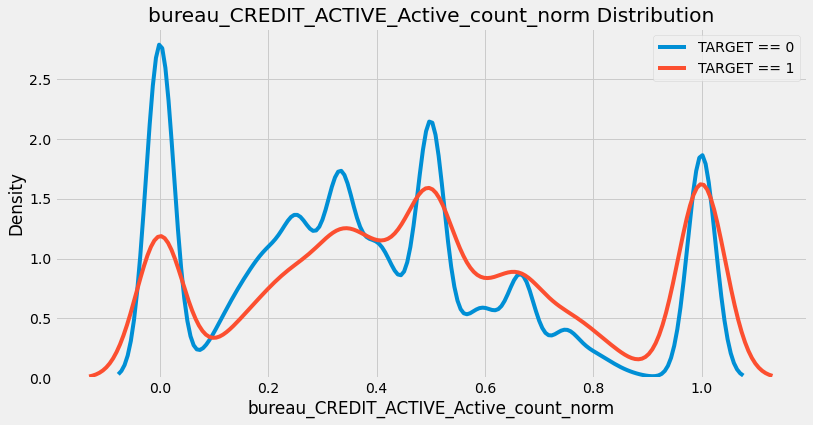

In [61]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

### Collinear Variables

In [62]:
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [63]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [64]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 199)
Testing Corrs Removed Shape:  (48744, 198)


In [65]:
#train_corrs_removed.to_csv(data_path + 'train_bureau_corrs_removed.csv', index = False)
#test_corrs_removed.to_csv(data_path + 'test_bureau_corrs_removed.csv', index = False)

In [66]:
ls_col = ['EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE',
       'TOTALAREA_MODE', 'HOUR_APPR_PROCESS_START', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'AMT_INCOME_TOTAL', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'FLAG_DOCUMENT_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'EXT_SOURCE_2',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'AMT_GOODS_PRICE']

# Modélisation 

In [67]:
control_train = pd.read_csv(data_path +'application_train.csv')

In [68]:
control_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

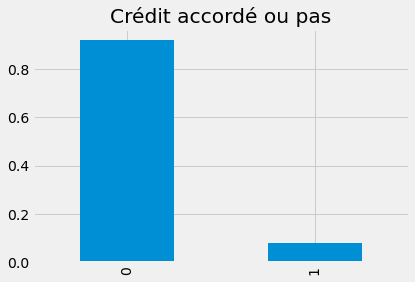

In [69]:
control_train["TARGET"].value_counts(normalize=True).plot.bar(title='Crédit accordé ou pas')

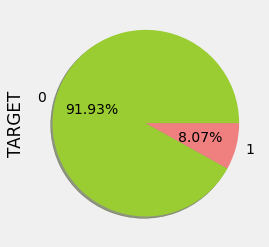

In [70]:
fig=plt.figure(figsize=(4,4))
colors = ['yellowgreen', 'lightcoral']
control_train["TARGET"].value_counts(normalize=True).plot(kind='pie',
                                                              colors=colors,
                                                              shadow=True,
                                                              autopct = lambda x: str(round(x, 2)) + '%')
plt.show()

In [71]:
train_data = control_train[control_train.columns[control_train.isna(
).sum()/control_train.shape[0] < 0.5]]

In [72]:
cat_var, num_var = handle_type(train_data)

In [73]:
df_cat = imputer_nan(train_data, "most_frequent", cat_var)
df_num = imputer_nan(train_data, "median", num_var)

In [74]:
dummies = pd.get_dummies(df_cat, drop_first=True)

In [75]:
concatenate_df = pd.concat([df_num, dummies], axis=1)

In [78]:
data = concatenate_df.sample(n=2000, random_state=1)

In [79]:
#data.to_csv(data_path + 'data_for_prediction.csv', index = False)

In [80]:
X = data.drop(columns=['TARGET'])
y = data['TARGET']

In [81]:
sm = SMOTE(random_state=42)

In [82]:
X_sm, y_sm = sm.fit_resample(X[ls_col], y)

In [83]:
X_sm.index

RangeIndex(start=0, stop=3684, step=1)

In [84]:
X_sm.shape

(3684, 17)

In [85]:
X_sm.head()

EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  REGION_POPULATION_RELATIVE  \
0      0.602386                 -1237.0                    0.005313   
1      0.492060                  -379.0                    0.010643   
2      0.535276                  -343.0                    0.032561   
3      0.345785                 -1269.0                    0.011703   
4      0.227613                  -524.0                    0.010006   

   TOTALAREA_MODE  HOUR_APPR_PROCESS_START  DAYS_BIRTH  DAYS_EMPLOYED  \
0          0.0688                      9.0    -20614.0       365243.0   
1          0.0688                     17.0     -9080.0        -1080.0   
2          0.1682                     14.0    -15933.0         -114.0   
3          0.0688                     16.0     -9926.0        -1061.0   
4          0.0355                      8.0    -11757.0        -1593.0   

   AMT_INCOME_TOTAL  OBS_60_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_3  \
0          135000.0                       0.0              1.0   
1          135000.0                       1.0              1.0   
2          112500.0                       1.0              1.0   
3          247500.0                       1.0              1.0   
4          202500.0                       0.0              1.0   

   OBS_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_2  DEF_60_CNT_SOCIAL_CIRCLE  \
0                       0.0      0.622652                       0.0   
1                       1.0      0.655960                       0.0   
2                       1.0      0.670793                       0.0   
3                       1.0      0.486120                       1.0   
4                       0.0      0.247563                       0.0   

   AMT_ANNUITY  DAYS_ID_PUBLISH  DEF_30_CNT_SOCIAL_CIRCLE  AMT_GOODS_PRICE  
0      31617.0          -3098.0                       0.0         585000.0  
1      25393.5          -1743.0                       0.0         202500.0  
2      16753.5          -4424.0                       0.0         139500.0  
3      36292.5          -2474.0                       1.0        1125000.0  
4      35158.5            -81.0                       0.0         900000.0

In [86]:
y_sm.value_counts(normalize=True)*100


0.0    50.0
1.0    50.0
Name: TARGET, dtype: float64

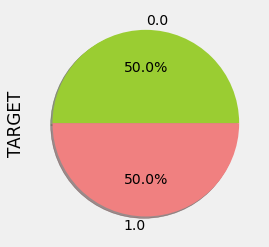

In [87]:
fig=plt.figure(figsize=(4,4))
colors = ['yellowgreen', 'lightcoral']
y_sm.value_counts(normalize=True).plot(kind='pie',
                                                              colors=colors,
                                                              shadow=True,
                                                              autopct = lambda x: str(round(x, 2)) + '%')
plt.show()

In [88]:
Xscaled = StandardScaler().fit_transform(X_sm)

In [89]:
df_scaled = pd.DataFrame(Xscaled, columns=X_sm.columns)

In [90]:
df_scaled.shape

(3684, 17)

In [91]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df_scaled, y_sm, test_size=0.25, random_state=1)


In [92]:
imbalanced_test = ytest.value_counts()[0].sum()/ytest.value_counts()[1].sum()
imbalanced_test


1.0696629213483146

In [93]:
imbalanced_train = ytrain.value_counts()[0].sum()/ytrain.value_counts()[1].sum()
imbalanced_train

0.9778095919828204

In [94]:
#model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [95]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [96]:
#('scaler', StandardScaler()), 

                  name  train_accuracy  test_accuracy  train_time  \
0          Naive Bayes        0.694535       0.664495    0.003685   
1  logistic regression        0.706840       0.710098    0.243875   
2        Decision Tree        1.000000       0.862106    0.026129   
3        Random Forest        1.000000       0.948969    0.463704   
4      LGBM Classifier        1.000000       0.954397    0.403641   
5    Gradient Boosting        0.949330       0.913138    0.719956   
6       MLP Classifier        0.925805       0.856678    3.462721   

                                               model  
0                                     (GaussianNB())  
1                           (LogisticRegressionCV())  
2                         (DecisionTreeClassifier())  
3  ((DecisionTreeClassifier(max_features='auto', ...  
4                                 (LGBMClassifier())  
5  (([DecisionTreeRegressor(criterion='friedman_m...  
6  (MLPClassifier(alpha=0.1, hidden_layer_sizes=(...  


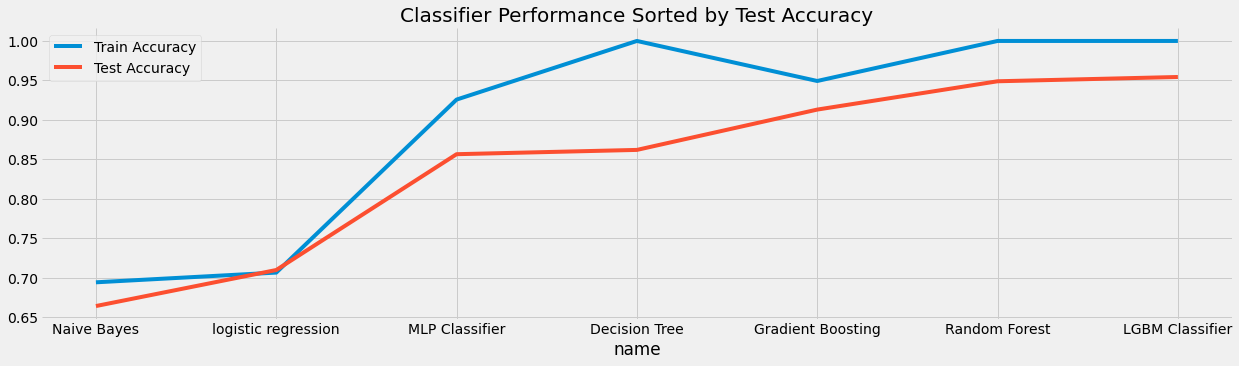

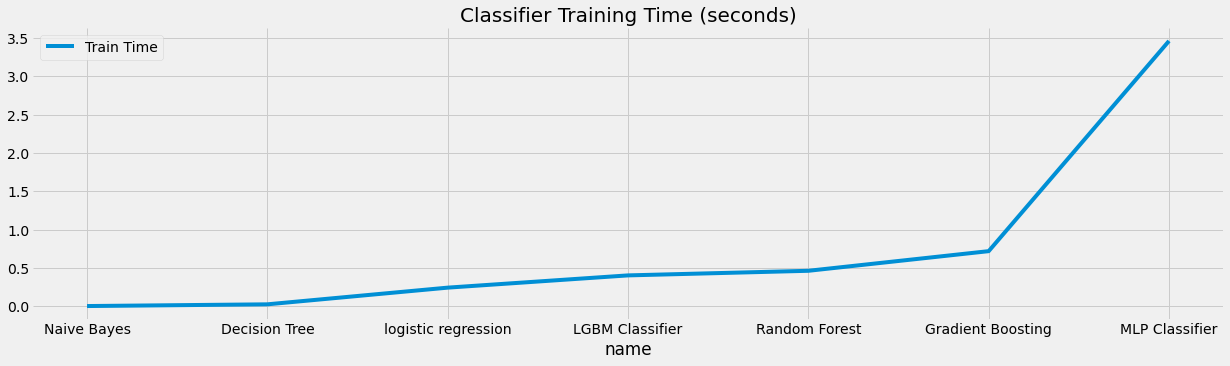

In [97]:
trained_models = []  # keep track of all details for models we train
def train_model(model, data, labels):
    pipe = Pipeline([('clf', model["clf"])])
    start_time = time.time()
    pipe.fit(Xtrain, ytrain)
    train_time = time.time() - start_time
    train_accuracy = pipe.score(Xtrain, ytrain)
    test_accuracy = pipe.score(Xtest, ytest)
    #train_accuracy = roc_auc_score(X_train, y_train)
    #test_accuracy = roc_auc_score(X_test, y_test)
    model_details = {
                    "name": model["name"], "train_accuracy": train_accuracy,
                     "test_accuracy": test_accuracy, "train_time": train_time, 
                     "model": pipe
                    }
    return model_details


models = [
                {"name": "Naive Bayes", "clf": GaussianNB()},
                {"name": "logistic regression", "clf": LogisticRegressionCV()},
                {"name": "Decision Tree", "clf": DecisionTreeClassifier()},
                {"name": "Random Forest","clf": RandomForestClassifier(n_estimators=100)},
                {"name": "LGBM Classifier","clf": lgb.LGBMClassifier(n_estimators=100)},
                {"name": "Gradient Boosting","clf": GradientBoostingClassifier(n_estimators=100)},
                {"name": "MLP Classifier", "clf": MLPClassifier(solver='adam', alpha=1e-1, 
                                                                hidden_layer_sizes=(10, 10, 5, 2), max_iter=500, 
                                                                random_state=42)}
    ]

for model in models:
    model_details = train_model(model, X, y)
    trained_models.append(model_details)


# visualize accuracy and run time
#setup_plot()
model_df = pd.DataFrame(trained_models)
print(model_df)
model_df.sort_values("test_accuracy", inplace=True)
ax = model_df[["train_accuracy", "test_accuracy", "name"]].plot(
    kind="line", x="name", figsize=(19, 5), title="Classifier Performance Sorted by Test Accuracy")
ax.legend(["Train Accuracy", "Test Accuracy"])
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 3)),
                (p.get_x() * 1.005, p.get_height() * 1.005))

ax.title.set_size(20)
plt.box(False)

model_df.sort_values("train_time", inplace=True)
ax = model_df[["train_time", "name"]].plot(kind="line", x="name", figsize=(
    19, 5), grid=True, title="Classifier Training Time (seconds)")
ax.title.set_size(20)
ax.legend(["Train Time"])
plt.box(False)

Text(0.5, 0.98, 'Feature Importance for Tree Models. Top 30 Features.')

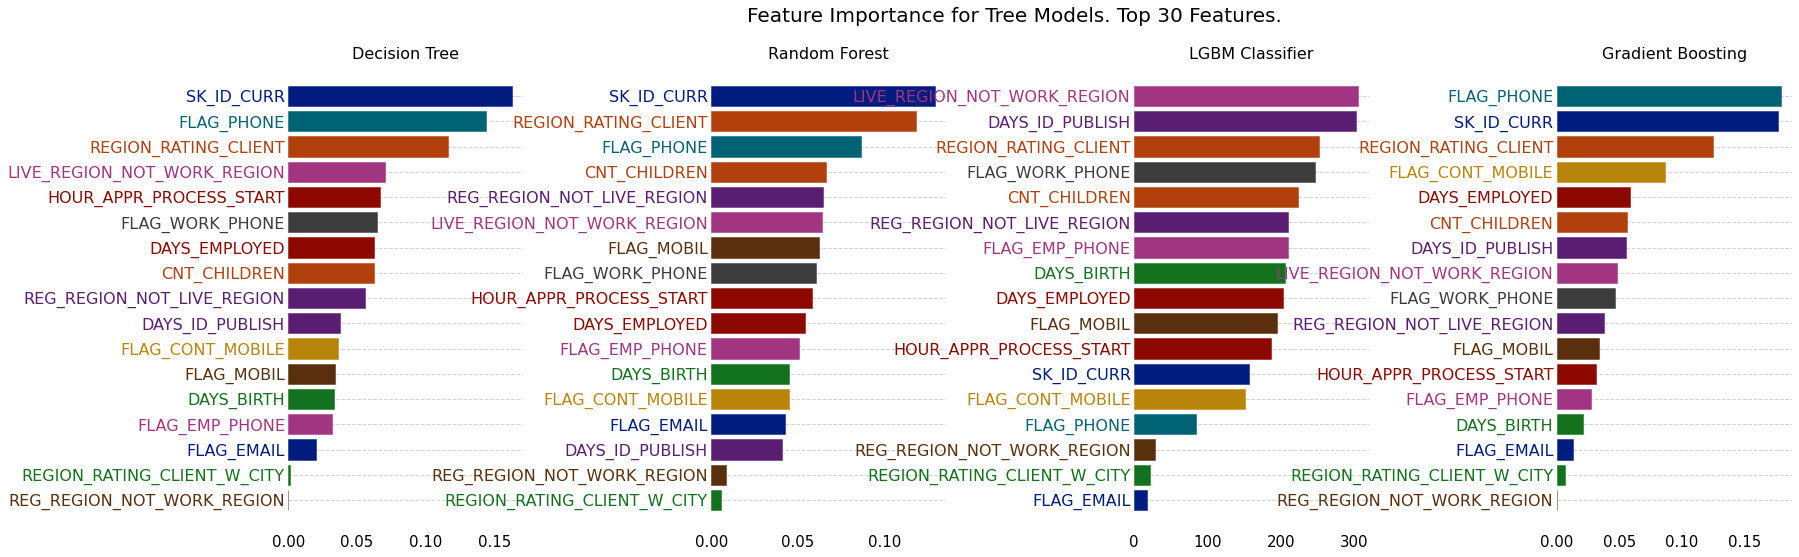

In [98]:
# @title
# Create array of tree based models and plot feature importance scores
#current_data
tree_models = []
setup_plot()
color_list = sns.color_palette("dark", len(X.columns))
top_x = 30  # number of x most important features to show
for model in trained_models:
    if hasattr(model["model"]["clf"], 'feature_importances_'):
        tree_models.append(
            {"name": model["name"], "fi": model["model"]["clf"].feature_importances_})


fig, axs = plt.subplots(1, 4, figsize=(24, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.8)
axs = axs.ravel()
for i in range(len(tree_models)):
    feature_importance = tree_models[i]["fi"]
    indices = np.argsort(feature_importance)
    indices = indices[-top_x:]
   

    bars = axs[i].barh(range(len(indices)),
                       feature_importance[indices], color='b', align='center')
    axs[i].set_title(tree_models[i]["name"], fontweight="normal", fontsize=16)

    plt.sca(axs[i])
    plt.yticks(range(len(indices)), [X.columns[j]
                                     for j in indices], fontweight="normal", fontsize=16)
  
    # print(len(plt.gca().get_yticklabels()), len(indices))
    for i, ticklabel in enumerate(plt.gca().get_yticklabels()):
        ticklabel.set_color(color_list[indices[i]])
        #labels.append(ticklabel)
        
    
   # print("Les features les plus importantes : ",labels)

    for i, bar in enumerate(bars):
        bar.set_color(color_list[indices[i]])
    plt.box(False)

plt.suptitle("Feature Importance for Tree Models. Top " +
             str(top_x) + " Features.", fontsize=20, fontweight="normal")

## Optimisation avec GridSearchCV 

In [99]:
# top_test = Xtest[ls_col]
# top_train =X_train[ls_col]

In [100]:
param_grid = { 
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 20, 30],
    'criterion' :['gini', 'entropy'],
}

In [101]:
grid = GridSearchCV(RandomForestClassifier(
    class_weight='balanced', random_state=42), param_grid, scoring="roc_auc", cv=5)

In [102]:
grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200, 500, 1000]},
             scoring='roc_auc')

In [103]:
print(grid.best_score_)
print(grid.best_params_)

0.9852754890251105
{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1000}


In [104]:
model = grid.best_estimator_

In [105]:
model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, n_estimators=1000, random_state=42)

### Learning Curve

[ 221  442  663  884 1105 1326 1547 1768 1989 2210]


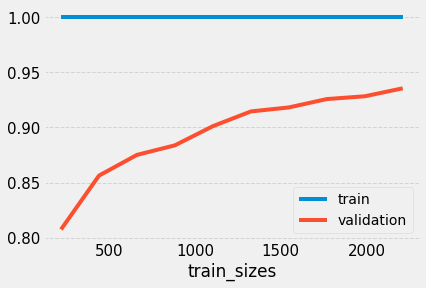

In [106]:
N, train_score, val_score = learning_curve(model, Xtrain, ytrain,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

### Confusion Matrix

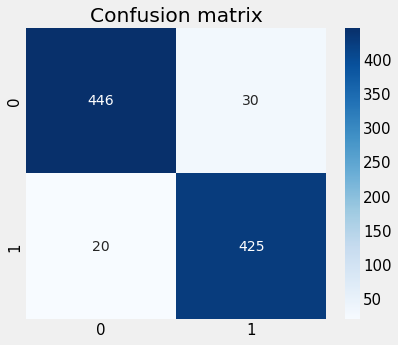

In [107]:
cm= confusion_matrix(ytest, model.predict(Xtest))
plt.figure(figsize=(6, 5))
plt.title('Confusion matrix')
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')

In [108]:
from sklearn.metrics import classification_report
#target_names = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
#print(classification_report(irisdata['Class'],kmeans.labels_,target_names=target_names))

In [109]:
print(classification_report(ytest, model.predict(Xtest)))

              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       476
         1.0       0.93      0.96      0.94       445

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



### Area under the receiver operator curve — roc_auc

In [136]:
roc_auc_score(ytest, model.predict_proba(Xtest)[:,1])

0.9873052591823247

## Constitution d'un dataframe avec score pour le Dashboard.

In [111]:
# y_hats = model.predict(X[ls_col])
# train_for_dash = X[ls_col]
# train_for_dash['preds'] = y_hats

In [112]:
# data_merged_score = pd.concat([data["SK_ID_CURR"], train_for_dash], axis=0)

In [113]:
# data["SK_ID_CURR"]

In [114]:
# train_for_dash.shape

In [115]:
# data_merged_score

##### Creer un fichier 

In [116]:
# test.to_csv("data_with_predict.csv")

In [119]:
#data_test = train_data

In [120]:
#data_test

In [121]:
#df_out = pd.merge(data_test,test['preds'],how = 'left',left_index = True, right_index = True)

In [122]:
#df_out

In [123]:
#y_test['preds'] = y_hats

#df_out = pd.merge(df,y_test[['preds']],how = 'left',left_index = True, right_index = True)

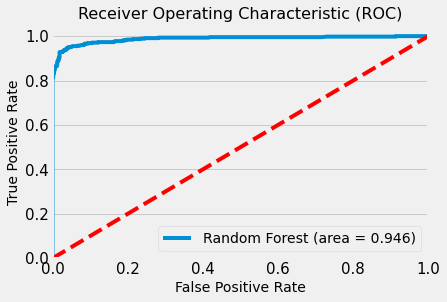

In [130]:
# Building ROC curve
rf_roc_auc = roc_auc_score(ytest, model.predict(Xtest))
fpr, tpr, thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.3f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
#plt.savefig('RF_ROC', fontsize=14)


In [134]:
preds = model.predict(Xtest)

In [135]:
print('Recall score :', recall_score(ytest, preds))

Recall score : 0.9550561797752809


# Interpretation

## Interprétation globale 

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


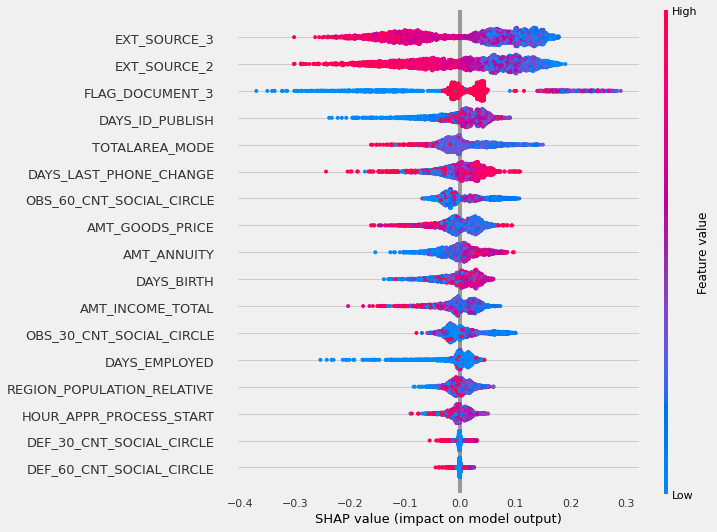

In [137]:
# Import the package
import shap
shap.initjs()

# Let us have a look on SHAP summary plot
%time
samples = Xtrain

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(samples, approximate=False, check_additivity=False)

shap.summary_plot(shap_values[1], samples)

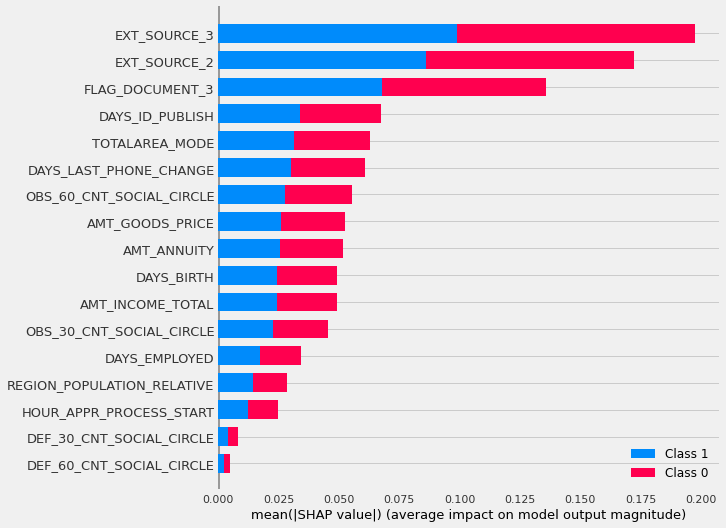

In [138]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(Xtrain)
shap.summary_plot(shap_values, Xtrain, plot_type="bar")

## Force_plot : Interprétation locale 

In [139]:
def shapley(xtrain, ytrain, xtest, row_number =0):
    pred = model.predict(xtest)
    row= xtest.iloc[[row_number]]
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(row)
    #get features names
    features_names = row.columns
    features_values = row.values[0]
    #shaps = pd.Series(shap_values[0], zip(features_names, features_values))
    # Visualizing the results of shap_values
    return shap.force_plot(
        base_value =explainer.expected_value[0],
        shap_values = shap_values[0],
        features = row
    )

In [140]:
shapley(Xtrain, ytrain, Xtest, row_number=1)

In [141]:
Xtest.iloc[[1]]

EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  REGION_POPULATION_RELATIVE  \
3130     -0.159914               -1.350322                   -0.981146   

      TOTALAREA_MODE  HOUR_APPR_PROCESS_START  DAYS_BIRTH  DAYS_EMPLOYED  \
3130       -0.268576                -0.020349   -1.096262       2.385629   

      AMT_INCOME_TOTAL  OBS_60_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_3  \
3130         -0.226688                 -0.619677          0.59398   

      OBS_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_2  DEF_60_CNT_SOCIAL_CIRCLE  \
3130                 -0.620915      0.978867                 -0.310583   

      AMT_ANNUITY  DAYS_ID_PUBLISH  DEF_30_CNT_SOCIAL_CIRCLE  AMT_GOODS_PRICE  
3130     0.134176         0.171804                 -0.352463         0.144337

In [142]:
Xtest.iloc[[5]]

EXT_SOURCE_3  DAYS_LAST_PHONE_CHANGE  REGION_POPULATION_RELATIVE  \
2037     -1.199621               -2.026458                   -0.469538   

      TOTALAREA_MODE  HOUR_APPR_PROCESS_START  DAYS_BIRTH  DAYS_EMPLOYED  \
2037       -0.398077                 1.119145   -0.948119       2.385629   

      AMT_INCOME_TOTAL  OBS_60_CNT_SOCIAL_CIRCLE  FLAG_DOCUMENT_3  \
2037         -0.150039                 -0.619677         0.264444   

      OBS_30_CNT_SOCIAL_CIRCLE  EXT_SOURCE_2  DEF_60_CNT_SOCIAL_CIRCLE  \
2037                 -0.620915      0.896523                 -0.310583   

      AMT_ANNUITY  DAYS_ID_PUBLISH  DEF_30_CNT_SOCIAL_CIRCLE  AMT_GOODS_PRICE  
2037    -0.069728         0.372143                 -0.352463         0.059169

In [143]:
shapley(Xtrain, ytrain, Xtest, row_number=1)

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'FLAG_DOCUMENT_3', 'DAYS_ID_PUBLISH',
       'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'DAYS_BIRTH', 'AMT_INCOME_TOTAL',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_EMPLOYED',
       'REGION_POPULATION_RELATIVE', 'HOUR_APPR_PROCESS_START',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'],
      dtype='object')


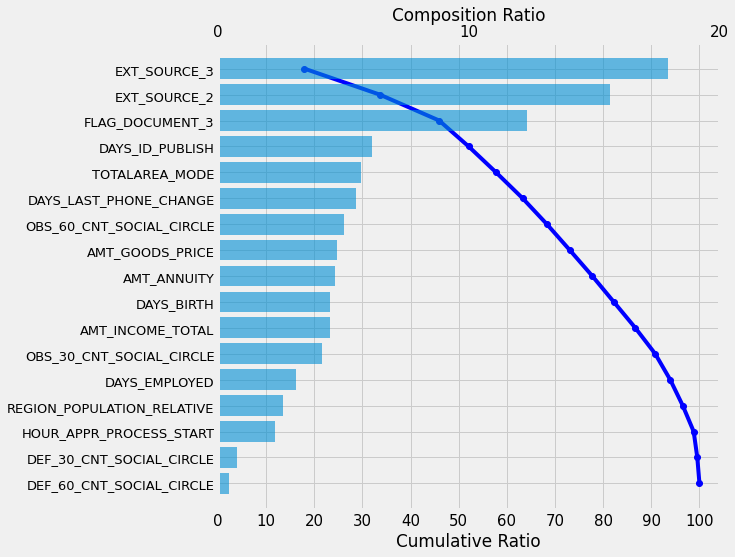

In [144]:
def make_shap_waterfall_plot(shap_values, features, num_display=20):
    column_list = features.columns
    feature_ratio = (np.abs(shap_values).sum(0) / np.abs(shap_values).sum()) * 100
    column_list = column_list[np.argsort(feature_ratio)[::-1]]
    feature_ratio_order = np.sort(feature_ratio)[::-1]
    cum_sum = np.cumsum(feature_ratio_order)
    column_list = column_list[:num_display]
    feature_ratio_order = feature_ratio_order[:num_display]
    cum_sum = cum_sum[:num_display]
    
    num_height = 0
    if (num_display >= 20) & (len(column_list) >= 20):
        num_height = (len(column_list) - 20) * 0.4
        
    fig, ax1 = plt.subplots(figsize=(8, 8 + num_height))
    ax1.plot(cum_sum[::-1], column_list[::-1], c='blue', marker='o')
    ax2 = ax1.twiny()
    ax2.barh(column_list[::-1], feature_ratio_order[::-1], alpha=0.6)
    
    ax1.grid(True)
    ax2.grid(False)
    ax1.set_xticks(np.arange(0, round(cum_sum.max(), -1)+1, 10))
    ax2.set_xticks(np.arange(0, round(feature_ratio_order.max(), -1)+1, 10))
    ax1.set_xlabel('Cumulative Ratio')
    ax2.set_xlabel('Composition Ratio')
    ax1.tick_params(axis="y", labelsize=13)
    plt.ylim(-1, len(column_list))
    print(column_list)
    return column_list
    # Shap waterfall plot
column_list= make_shap_waterfall_plot(shap_values[1], samples)

In [145]:
# Sur la base du diagramme en cascades SHAP (waterfall plot), 
# nous pouvons dire que EXT_SOURCE_3 et Day_last_phone_change sont les caractéristiques les plus importantes du modèle, 
# Elles  contribuent chacune à environ de 10% de l'explicabilité du modèle. 

# En outre, Les 20 premières caractéristiques fournissent plus de 60 % de l'interprétation du modèle.

In [146]:
# # Let's have a look on the top features and their dependence plots
# top_features = ['EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE', 'REGION_POPULATION_RELATIVE',
#        'TOTALAREA_MODE', 'HOUR_APPR_PROCESS_START']

# # Visualizing top features
# for feature in top_features:
#     shap.dependence_plot(feature, shap_values[1], samples, interaction_index=None)

### Modèle avec Pickle

In [148]:
pipe_pred = Pipeline([('clf', RandomForestClassifier(**grid.best_params_))])

In [149]:
pipe_pred.fit(Xtrain, ytrain)

Pipeline(steps=[('clf',
                 RandomForestClassifier(criterion='entropy', max_depth=30,
                                        n_estimators=1000))])

In [150]:
pipe_pred.score(Xtrain,ytrain)

1.0

In [151]:
pipe_pred.score(Xtest,ytest)

0.9489685124864278

In [152]:
# save the model to disk
filename = 'finalized_model_fastapi.pkl'
pickle.dump(pipe_pred, open(filename, 'wb'))

In [153]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(Xtest, ytest)
print(result)

0.9489685124864278
